# Project 1

The project is meant to illustrate how images taken from spacecraft can be reconstructed when there is missing data, which is common in space photography. The images we work with are 

titan.jpg
rosetta.jpg

. These refer to the Titan, which is the largest moon of Saturn, and probably the Rosetta sattelite lauched by the ESA to photograph the 67P comet.

What we want to do is to:

1. Preprocess the image by:
        - transform to 0. -> 1. greyscale
        - Remove each pixel with probability p_c = 0.5.
        - Split the image into observed x_o and missing x_m pixels.
        
2. Use LS approximation as in Computer excercise 3 to estimate a linear parameters. Then reconstruct by estimating the Matern covariance function
    
3. Use LS approximation again, but this time reconstruct using the GMRF with precision matrix $\tau \boldsymbol{Q}$ where $\boldsymbol{Q}$ is the stencil and $\tau = \frac{2 \pi}{\sigma^2}$

4. Ivestigate how the missing pixels affect the reconstruction. 

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


"""
Loading an image as a numpy array. Not possible for large images.
"""
def load_image(infilename, dtype = "int32") :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype=dtype )
    return data, img

### 1. Preprocessing

In [2]:
# Loading the image
data, img = load_image("titan.jpg", dtype="float32")
print(data.shape)
m = data.shape[0]
n = data.shape[1]

(215, 126)


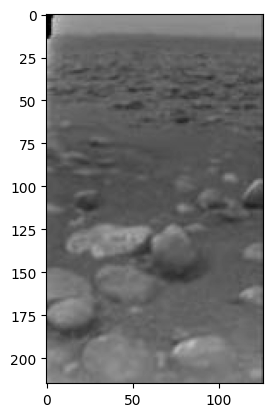

In [3]:
# Normalize and plot
data = data/255
plt.imshow(data, cmap='gray', vmin=0, vmax=1.)

In [4]:
# Removing the pixel values.

# This is the probability that any pixel in the image is missing.
p_c = 0.5
u = np.random.uniform(size=data.shape)
# A True boolean means that pixel is keept.
mask = np.greater(u, p_c)


Not a nice picture :(

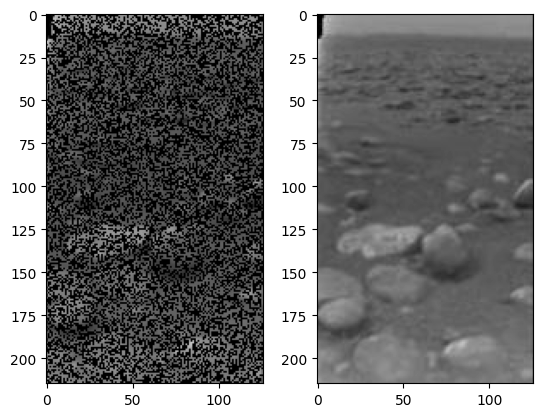

In [5]:
fig, axs = plt.subplots(1, 2)
corrupted_data = data * mask
axs[0].imshow(corrupted_data, cmap='gray', vmin=0, vmax=1.)
axs[1].imshow(data, cmap='gray', vmin=0, vmax=1.)


In [6]:
# Splitting the data into observed and missing values.

# Make a grid
X, Y = np.meshgrid(np.arange(0, n), np.arange(0, m))

loc = np.concatenate((X.reshape(n*m, 1), Y.reshape(n*m, 1)), axis = 1)

ind_obs = np.flatnonzero(mask.flatten())
ind_m = np.flatnonzero(mask.flatten() == False)

loc_obs = loc[ind_obs, :]
loc_m = loc[ind_m, :]

### 2. LS estimation and Matérn covariance fit.

In [7]:
def get_LS_estimates(loc_obs, data):
    N = loc_obs.shape[0]
    B_obs = np.concatenate((np.ones([N, 1]), loc_obs), axis = 1)
    Z_obs = data[loc_obs[:, 1], loc_obs[:, 0]]
    
    left = np.linalg.inv(np.matmul(B_obs.T, B_obs))
    right = np.matmul( B_obs.T, Z_obs.reshape(N, 1) )
    LSE = np.matmul(left, right)
    res = (Z_obs.reshape(N, 1) - np.matmul(B_obs, LSE)).flatten()

    return LSE, res


In [8]:
#For the small image we opt to use all observed values.
#print(len(ind_obs))
N = len(ind_obs)
#N = 10000

#B_obs = np.concatenate((np.ones([N, 1]), loc_obs[:N, :]), axis = 1)
#print(B_obs.shape)
#print(B_obs[:5, :])

#Z_obs = data[loc_obs[:N, 1], loc_obs[:N, 0]]

In [9]:
#left = np.linalg.inv(np.matmul(B_obs.T, B_obs))
#right = np.matmul( B_obs.T, Z_obs.reshape(N, 1) )
#LSE = np.matmul(left, right)  

#LSE = (Bo'*Bo)\Bo'*Observed_values;
LSE, res = get_LS_estimates(loc_obs[:N], data)
print(LSE)

# Residuals
print(res.shape)

[[ 3.87497709e-01]
 [-2.92225716e-04]
 [ 2.10140250e-04]]
(13640,)


In [10]:
from matlab_functions import emp_variogram
empi_var = emp_variogram(loc_obs[:N, :], res, 100)

#out['h'] = (d[1:] + d[:-1]) / 2
#out['variogram'] = np.zeros(N-1)
#out['N'] = np.zeros(N-1)

In [11]:
from matlab_functions import cov_ls_est
lse_estimates = cov_ls_est(res, 'matern', empi_var)
    
print(lse_estimates)

{'sigma': 5823.681135694852, 'kappa': 5.135174713295927e-24, 'nu': 0.22785266848006525, 'sigma_e': 0.03348105323382232}


In [12]:
from matlab_functions import matern_variogram

h = np.linspace(0, 250, 1000)
mat_v_new = matern_variogram(h,
                             lse_estimates['sigma'],
                             lse_estimates['kappa'],
                             lse_estimates['nu'],
                             lse_estimates['sigma_e'])


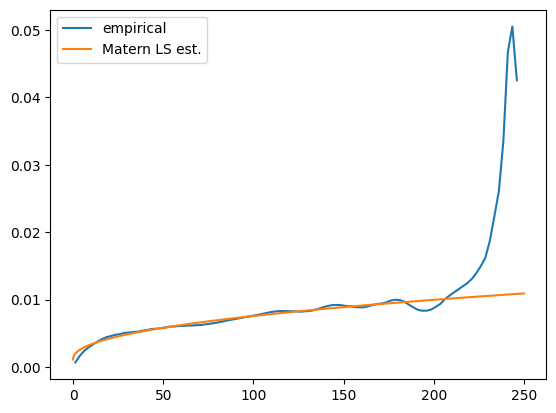

In [13]:
fig, ax = plt.subplots()
ax.plot(empi_var['h'], empi_var['variogram'], label="empirical")
ax.plot(h, mat_v_new, label="Matern LS est.")
ax.legend()

Find the estimators

In [14]:
from matlab_functions import matern_covariance
from scipy.spatial.distance import squareform, pdist

D_obs = squareform(pdist(loc_obs[:N]))
               
#Covariance matrix
S_obs_obs = np.zeros([N, N])
for i in range(N):
    S_obs_obs[i, :] = matern_covariance(D_obs[i, :],
                          lse_estimates['sigma'], 
                          lse_estimates['kappa'],
                          lse_estimates['nu'])
    
D_obs = None


In [15]:
print("here")
So = lse_estimates['sigma_e']**2. * np.eye(N) + S_obs_obs
#Q = np.linalg.inv(So)
print("here")
B_obs = np.concatenate((np.ones([N, 1]), loc_obs[:N]), axis = 1)
Z_obs = data[loc_obs[:N, 1], loc_obs[:N, 0]]


gls = np.linalg.solve(B_obs.T @ np.linalg.solve(So, B_obs), B_obs.T @ np.linalg.solve(So, Z_obs.reshape(N, 1) ))



here
here


In order to calculate predictions using our values we need to do kriging. The squareform matrix is too large to use, luckily we only need some partial matrices to perform our calculations.

In [16]:
print(gls)
print(LSE)

[[ 4.74355389e-01]
 [-4.05768367e-04]
 [ 4.75231657e-05]]
[[ 3.87497709e-01]
 [-2.92225716e-04]
 [ 2.10140250e-04]]


In [17]:
from scipy.spatial import distance_matrix

B_m = np.concatenate((np.ones([loc_m.shape[0], 1]), loc_m), axis = 1)

mu2 = np.matmul(B_m, gls)
mu1 = np.matmul(B_obs, gls)


D_obs_m = distance_matrix(loc_obs[:N], loc_m)
S_obs_m = np.zeros([N, loc_m.shape[0]])
half = loc_m.shape[0]//2
for i in range(N):
    S_obs_m[i, :half] = matern_covariance(D_obs_m[i, :half],
                          lse_estimates['sigma'], 
                          lse_estimates['kappa'],
                          lse_estimates['nu'])
    S_obs_m[i, half:] = matern_covariance(D_obs_m[i, half:],
                          lse_estimates['sigma'], 
                          lse_estimates['kappa'],
                          lse_estimates['nu'])

D_obs_m = None


In [18]:
#left = np.matmul(S_obs_m.T, Q)
#gls_res = (Z_obs.reshape(N, 1) - np.matmul(B_obs, gls)).flatten()
#krig = mu2 + np.matmul(left, (Z_obs.reshape(N, 1) - np.matmul(B_obs, gls)).reshape(N, 1))
krig = mu2 + S_obs_m.T @ np.linalg.solve(So, (Z_obs.reshape(N, 1) - mu1))

In [19]:
observed_data = corrupted_data[loc_obs[:, 1], loc_obs[:, 0]]
observed_data = observed_data.reshape([len(observed_data), 1])
Z_rec = np.zeros([m*n, 1])
Z_rec[ind_obs, :] = observed_data
Z_rec[ind_m, :] = krig

Text(0.5, 0.98, 'Corrupted vs Reconstructed vs Original')

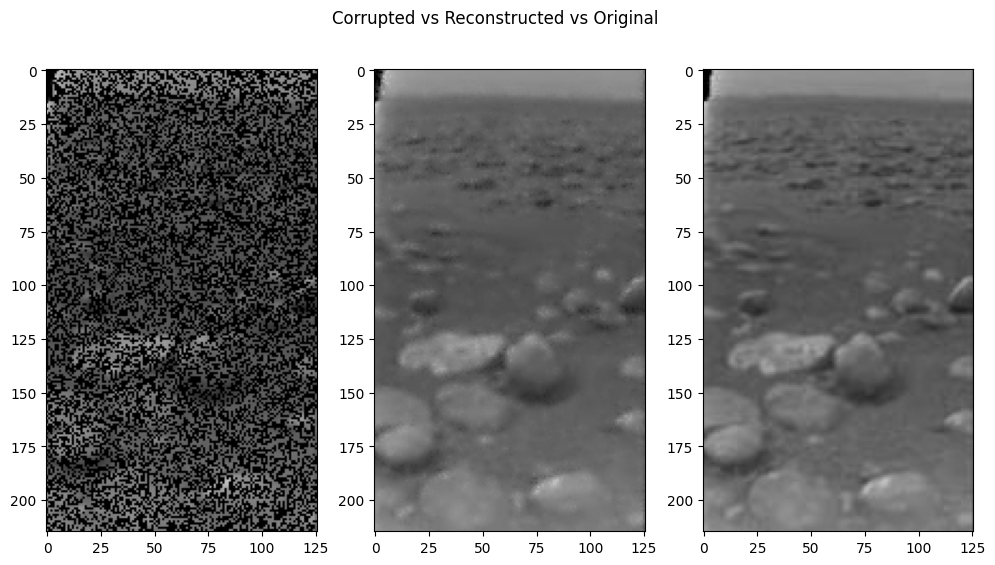

In [20]:
reconstructed_image = Z_rec.reshape([m, n])

fig, axs = plt.subplots(1, 3)
fig.set_figwidth(12)
fig.set_figheight(6)

axs[0].imshow(corrupted_data, cmap='gray', vmin=0, vmax=1.)
axs[1].imshow(reconstructed_image, cmap='gray', vmin=0, vmax=1.)
axs[2].imshow(data, cmap='gray', vmin=0, vmax=1.)
fig.suptitle("Corrupted vs Reconstructed vs Original")
